# GNR -- Gandhi, Navarro, Rivers

# Summary of the GNR method: 

Derivation of the model: 

The firm's profit maximization problem with respect to intermediate inpouts is: 

$$
\max_{M_{jt}} P_t \mathbb E\left[F(k_{jt}, l_{jt}, m_{jt})e^{\omega_{jt}+ \epsilon_{jt}}\right] - \rho_t M_{jt}. 
$$

and the first-order condition is: 

$$
P_t \frac{\partial}{\partial M_{jt}}F(k_{jt}, l_{jt}, m_{jt})e^{\omega_{jt}} \mathcal E = \rho_t . 
$$

with $\mathcal E \equiv e^{\epsilon_{jt}}$. Take Logs: 

$$
\ln P_t +\ln\left(\frac{\partial}{\partial M_{jt}}F(k_{jt}, l_{jt}, m_{jt})\right) + {\omega_{jt}} + \ln \mathcal E = \ln \rho_t . 
$$

Now subtract $\ln Y = \ln F(k_{jt}, l_{jt}, m_{jt}) + {\omega_{jt}} + \epsilon_{jt}$  from both sides

$$
\ln \mathcal E +\ln\left(\frac{\partial}{\partial M_{jt}}F(k_{jt}, l_{jt}, m_{jt})\right) - {\epsilon_{jt}}  = \ln \rho_t  - \ln P_t - \ln Y_t + \ln F(k_{jt}, l_{jt}, m_{jt}). 
$$


First, we want to estimate the elasticity $D^{\mathcal E}(k_{jt}, l_{jt}, m_{jt}) = \operatorname{PolynomialFit}(k_{jt}, l_{jt}, m_{jt})$. To find the coefficients of the polynomials, we run the estimator 

$$
\min_{\gamma'} \sum_{j, t} \left\{  s_{jt} - \ln\underbrace{\begin{pmatrix} \gamma_0'+\gamma_k'k_{jt}+\gamma_l'l_{jt}+ \gamma_m' m_{jt} + \gamma_{kk}' k_{jt}^2 + \gamma_{ll}' l_{jt}^2 \\ \gamma_{mm}' m_{jt}^2 + \gamma_{kl}' k_{jt}l_{jt} + \gamma_{km}' k_{jt} m_{jt} + \gamma'_{lm} l_{jt} m_{jt}\end{pmatrix}}_{D^\mathcal E} \right\}^2
$$

where $s_{jt} \equiv \ln\left(\frac{\rho_t M_{jt}}{P_t Y_t}\right)$ is the log intermediate share of input. 


# Identification Procedure:
For a simple example, suppose $\omega_{it} = \rho \omega_{it-1} + \xi_{it}.$ Then
$g(x) = E[x|\omega_{it-1}] = \rho \omega_{it-1}.$ Assume labor is chosen after time $t-1$. Then the estimation procedure is: 

## (1) Regress $y_{it}$ on $\left(k_{it}, l_{it}, m_{it}\right)$ nonparametrically, or using a high-order polynomial, to obtain $\hat{\tilde \Phi}_t\left(k_{it}, l_{it}, m_{it}\right).$

We do this for every period to get a sequence of functions of $(k, l, m).$ These will be plugged in for $\Phi$ in the next step. 

## (2) Use the following four moment conditions to estimate the parameters $\left(\beta_0, \beta_k, \beta_l, \rho\right):$

$$
E\left[\left(y_{it} - \beta_0 - \beta_k k_{it} - \beta_l l_{it} - \rho\left(\tilde \Phi_{t-1}\left(k_{it-1}, l_{it-1}, m_{it-1}\right) - \beta_0 - \beta_k k_{it-1} - \beta_l l_{it-1}\right)\right) \otimes \begin{pmatrix} 1 \\ k_{it} \\ l_{it-1} \\ \tilde \Phi_{t-1}\left(k_{it-1}, l_{it-1}, m_{it-1}\right) \\ \end{pmatrix} \right] = 0
$$

Here's where we use GMM. 

# Load in the data


In [35]:
import autograd.numpy as np
from autograd import grad
#import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from itertools import combinations_with_replacement, chain

In [36]:
filename = "../PS3_data_changedtoxlsx.xlsx"
df0 = pd.read_excel(filename)

df = df0[['year', 'firm_id', 'X03', 'X04', 'X05', 'X40', 'X43', 'X44']]
#new_names = ["year", "firm_id", "obs", "ly", "s01", "s02", "lc", "ll", "lm"]
new_names = ["t", "firm_id", "y", "s01", "s02", "k", "l", "m"]

df.columns = new_names
#Keep industry 1 only
df=df[df['s02']==1]
#Creating lagged variables
df = df.sort_values(by=['firm_id', 't'])
df['kprev'] = df.groupby('firm_id')['k'].shift(1)
df['lprev'] = df.groupby('firm_id')['l'].shift(1)
df['mprev'] = df.groupby('firm_id')['m'].shift(1)

# First step of coding: Write functions for the estimation of $\tilde \Phi_t.$

In [38]:
def poly_terms(n_features, degree):
    #This thing creates an iterator structure of tuples, used to create polynomial interaction terms. 
    #It looks something like this: (0,), (1,), (2,), (0, 0), (0, 1) 
    polynomial_terms = chain(
        *(combinations_with_replacement(range(n_features), d) for d in range(1, degree+1))
    )
    return(polynomial_terms)

def fit_phi_poly(y, xvars, degree):
    #Get number of observations (n) and number of independent variables (k)
    if xvars.ndim == 1:
        xvars = xvars.reshape(1, -1)
    # Get the number of samples (n) and number of features (m) from X
    n_samples, n_features = xvars.shape
    
    # Start with a column of ones for the intercept term
    X_poly = np.ones((n_samples, 1))

    #Create iterator used to construct polynomial terms
    polynomial_terms = poly_terms(n_features, degree)
    
    # Generate polynomial terms and interaction terms up to 4th degree
    for terms in  polynomial_terms:  # For degrees 1 to 4
            X_poly = np.hstack((X_poly, np.prod(xvars[:, terms], axis=1).reshape(-1, 1)))
    
    # Compute the coefficients using the normal equation: beta = (X.T * X)^(-1) * X.T * y
    XT_X = X_poly.T @ X_poly
    XT_X_inv = np.linalg.inv(XT_X)
    XT_y = X_poly.T @ y
    beta = XT_X_inv @ XT_y

    return beta

#Function to evaluate the fitted values of the polynomial regression
def eval_phi_poly(xvars, degree, beta):

    if xvars.ndim == 1:
        xvars = xvars.reshape(1, -1)
    # Get the number of samples (n) and number of features (m) from X
    n_samples, n_features = xvars.shape
    # Create polynomial terms iterator
    polynomial_terms = poly_terms(n_features, degree)

    # Start with a column of ones for the intercept term
    X_poly = np.ones((n_samples, 1))
    
    # Generate polynomial terms and interaction terms up to 4th degree
    for terms in  polynomial_terms:  # For degrees 1 to 4
            X_poly = np.hstack((X_poly, np.prod(xvars[:, terms], axis=1).reshape(-1, 1)))
    
    #X_poly[np.isnan(X_poly).any(axis=1)] = 0
    
    yhat = X_poly@beta
    return yhat

## Estimate $\Phi$

In [39]:
degree= 3
xvars = df[['k', 'l', 'm']].to_numpy()
y = df[['y']].to_numpy()
gammas = fit_phi_poly(y, xvars, degree)
Phi = eval_phi_poly(xvars, degree, gammas)

## Actual by predicted plot for my polynomial approximation of $\Phi$, run on the entire sample

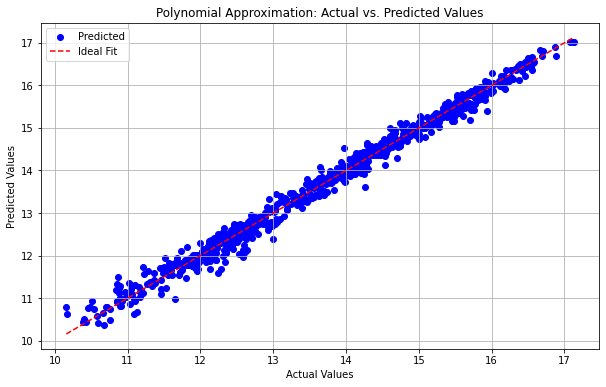

In [40]:
# Example data (replace these with your actual y and yhat values)
# Create a scatter plot for actual vs. predicted
plt.figure(figsize=(10, 6))
plt.scatter(y, Phi, color='blue', label='Predicted', marker='o')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label='Ideal Fit')

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Polynomial Approximation: Actual vs. Predicted Values')
plt.legend()
plt.grid()

# Show the plot
plt.show()

In [41]:
#phi_beta_dict = fit_phi_poly_years(df, degree)
df["Phi"] = Phi
#Add into the dataframe
df['Phiprev'] = df.groupby('firm_id')['Phi'].shift(1)
#drop NaNs

Now, we've calculated Phi and its lagged value. 
## Next step: "Concentrate out" additional moments

let 

$$
\widehat{\tilde\beta_0 + \omega_{it}(\beta_k, \beta_l)} = \hat{\tilde \Phi_t}(k_{it}, l_{it}, m_{it}) - \beta_k k_{it} - \beta_l l_{it}
$$

Then regress $\widehat{\tilde\beta_0 + \omega_{it}(\beta_k, \beta_l)}$ on $\widehat{\tilde\beta_0 + \omega_{it-1}(\beta_k, \beta_l})$, noting that the residuals of this regression are the implied values of the innovations in omega, that is, $\hat \xi_{it}(\beta_k, \beta_l).$

Notice that this regression implicitly makes these innovations mean zero and uncorrelated with $\omega_{it-1}(\beta_k, \beta_l)$, so it is similar to enforcing the first and fourth moments in the "four moments" version of this etimation. 

Then, search over $\beta_k$ and $\beta_l$ to satisfy the moment conditions: 

$$
E\left[ \hat \xi_{it}(\beta_k, \beta_l) \otimes \begin{pmatrix}k_{it} \\ l_{it-1}\end{pmatrix} \right] = 0. 
$$



In [88]:
#Calculates the error term, h(theta, y, k, l)
def moment_error_ACF(theta, y, k, l, kprev, lprev, Phi, Phiprev):
    #get the innovations to omega
    beta_k = theta[0]
    beta_l = theta[1]
    b0_plus_omega = Phi - beta_k*k - beta_l*l 
    b0_plus_omega_prev = Phiprev - beta_k*kprev - beta_l*lprev 
    #Regress them to get the innovations
    yvar = b0_plus_omega#.reshape(-1, 1)
    xvar = b0_plus_omega_prev.reshape(-1, 1)
    
    omega_degree = 1
    
    coeffs = fit_phi_poly(yvar, xvar, degree = omega_degree)
    #evaluate
    b0_plus_omega_hat = eval_phi_poly(xvar, degree=omega_degree, beta=coeffs)
    #Get residual
    xi = b0_plus_omega -  b0_plus_omega_hat
    #xi = fit_phi_poly(df['b0_plus_omega'].to_numpy().reshape(1, -1), df['b0_plus_omega'].to_numpy().reshape(1, -1), degree=1)
    #remove nans (associated with the lag) -- this is ok because we're just using this vector as part of a dot product. 
    return xi, coeffs[1]

def moment_ex_restrictions_ACF(k, lprev):
    #Moment conditions include exogeneity restrictions for 1, k_{it}, l_{it-1}, and Phi. 
    #Put them all in one matrix for easy access, called Vexc (short for vectors for exogeneity restrictions)
    #Replace all nans with zeros -- this is ok, because we're just taking a dot product over each row of this matrix, and want to remove the nans
    Vex = np.vstack([
        k, 
        lprev])
    return Vex

def gmm_obj_ACF(theta, y, k, l, kprev, lprev, Phi, Phiprev, Vex, W):
    #Arguments
    #Get the vector h(theta, y, k, l)
    xi = moment_error_ACF(theta, y, k, l, kprev, lprev, Phi, Phiprev)[0]
    #Calculate the "error" -- exogenous terms (dotproduct) h(theta, y, k, l)
    err = Vex@xi
    #Calculate the weighted sum of the error using the weight matrix, W
    obj = err.T@W@err
    return obj

## Quick test -- evaluating the GMM objective function at $\theta = \mathbf 1$. 

In [89]:
df_nonans = df.dropna()
#df_nonans = df.copy()
#df_nonans.loc[df_nonans.isnull().any(axis=1)] = 0

#Get all the variables out of the dataframe -- This allows me to use Autograd
y = df_nonans['y'].to_numpy() 
k = df_nonans['k'].to_numpy()  
l = df_nonans['l'].to_numpy()  
Phi = df_nonans['Phi'].to_numpy() 
kprev = df_nonans['kprev'].to_numpy()  
lprev = df_nonans['lprev'].to_numpy() 
Phiprev = df_nonans['Phiprev'].to_numpy() 
#Run GMM
#Initial guess for parameters beta_0, beta_k, beta_l, rho
theta0 = np.array([1,1])
#Weight matrix -- use the identity for now. 
W0 = np.eye(2)
#(2) Get matrix of variables used in exogeneity restrictions
Vex = moment_ex_restrictions_ACF(k, lprev)
#Evaluate the GMM error
obj = gmm_obj_ACF(theta0, y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0)
obj

#Create  automatic gradient
autogradient = grad(gmm_obj_ACF)

#
xi = moment_error_ACF(theta, y, k, l, kprev, lprev, Phi, Phiprev)[0]

NameError: name 'df' is not defined

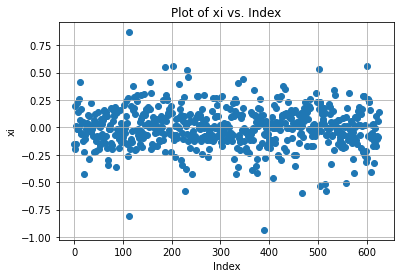

In [69]:
plt.scatter(range(len(xi)), xi, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("xi")
plt.title("Plot of xi vs. Index")
plt.grid(True)
plt.show()

## Now, use a minimization routine to optimize for theta. 

In [86]:
theta0 = np.array([1, 1])/2
bounds = [(-0.5, 2), (-0.5, 2)]

#theta0 = np.array([0.5, 1.6])

#Weight matrix -- use the identity for now. 
W0 = np.eye(2)
#(2) Get matrix of variables used in exogeneity restrictions
Vex = moment_ex_restrictions_ACF(k, lprev)

gmm_args = (y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0)


theta_results = opt.minimize(gmm_obj_ACF, theta0, args=gmm_args,
                        tol=1e-16, method='Nelder-Mead', options={'maxiter': 2000}, 
                             bounds = bounds)

theta_results_grad = opt.minimize(gmm_obj_ACF, theta0, args=gmm_args,
                       tol=1e-16, jac=autogradient, method='L-BFGS-B',                              
                        options={'ftol': 1e-10, 'gtol': 1e-10, 'maxiter': 2000},
)

#autogradient(theta_results, *gmm_args)

theta=theta_results.x
#Get the slope, rho. It's the slope of the regression used to find the moments. 
rho = moment_error_ACF(theta, y, k, l, kprev, lprev, Phi, Phiprev)[1]

print("The GMM error is:", gmm_obj_ACF(theta, y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0))
print("The estimates using Nelder-Mead are: [beta_k, beta_l] = ", theta)
print("The slope of the AR(1) of productivity is: rho = ", rho)
print("The estimates using autograd: [beta_k, beta_l] = ", theta_results_grad.x)


The GMM error is: 2.1218614496090376e-16
The estimates using Nelder-Mead are: [beta_k, beta_l] =  [0.46845648 0.59230075]
The slope of the AR(1) of productivity is: rho =  0.3981235469618696
The estimates using autograd: [beta_k, beta_l] =  [0.46845648 0.59230075]


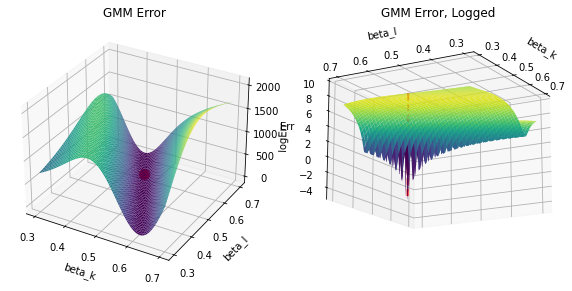

In [87]:
#plotrange = np.linspace(-1, 10, 300)
plotrange = np.linspace(0.3, 0.7, 300)
# Define the grid over which to plot
theta_grid1 = plotrange
theta_grid2 = plotrange
TH1, TH2 = np.meshgrid(theta_grid1, theta_grid2)

# Define the function to plot
# Calculate Z values using a for loop
Z0 = np.zeros_like(TH1)
for i in range(TH1.shape[0]):
    for j in range(TH1.shape[1]):
        TH = np.array([TH1[i, j], TH2[i, j]])
        Z0[i, j] = gmm_obj_ACF(TH, y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0 )

Zlog = np.log(Z0)
Z = Z0

#Our estimated value
x0, y0 = theta_results.x[0], theta_results.x[1]  
z0 = gmm_obj_ACF(np.array([x0, y0]), y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0 )

# Create the figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')  # Second subplot for logged


# Plot the unlogged surface
surf1 = ax1.plot_surface(TH1, TH2, Z, cmap='viridis')
#fig.colorbar(surf1, ax=ax1, shrink=0.2, aspect=5)
ax1.set_xlabel('beta_k')
ax1.set_ylabel('beta_l')
ax1.set_zlabel('Err')
ax1.set_title('GMM Error')

# Plot the logged surface
surf2 = ax2.plot_surface(TH1, TH2, Zlog, cmap='viridis')
#fig.colorbar(surf2, ax=ax2, shrink=0.2, aspect=5)
ax2.set_xlabel('beta_k')
ax2.set_ylabel('beta_l')
ax2.set_zlabel('logErr')
ax2.set_title('GMM Error, Logged')
# Draw a vertical line from the surface point down to z=0
ax2.plot([x0, x0], [y0, y0], [-4, 10], color='red', linewidth=2, linestyle='--')
# Plot the surface
# Draw a vertical line from the surface point down to z=0
ax1.scatter(x0, y0, z0, color='red', s=100, marker='o')
#ax2.scatter(x0, y0, z0, color='red', s=100, marker='o')

# Set labels
#ax2.set_zscale('log')

#x1.view_init(elev=0, azim=200)  # Adjust azim to rotate right
ax2.view_init(elev=-15, azim=-150)  # Adjust azim to rotate right


plt.show()



## The surface is very flat and difficult to find an optimum over. I think the spikes in the log plot are due to numerical error. 
But, it looks like we got roughly close to the optimum. 

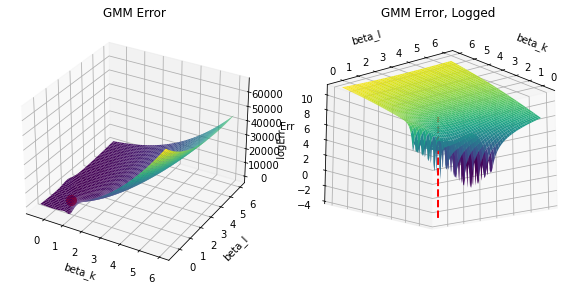

In [32]:
plotrange = np.linspace(-0.5, 6, 300)
#plotrange = np.linspace(0.3, 0.7, 300)
# Define the grid over which to plot
theta_grid1 = plotrange
theta_grid2 = plotrange
TH1, TH2 = np.meshgrid(theta_grid1, theta_grid2)

# Define the function to plot
# Calculate Z values using a for loop
Z0 = np.zeros_like(TH1)
for i in range(TH1.shape[0]):
    for j in range(TH1.shape[1]):
        TH = np.array([TH1[i, j], TH2[i, j]])
        Z0[i, j] = gmm_obj_ACF(TH, y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0 )

Zlog = np.log(Z0)
Z = Z0

#Our estimated value
x0, y0 = theta_results.x[0], theta_results.x[1]  
z0 = gmm_obj_ACF(np.array([x0, y0]), y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0 )

# Create the figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')  # Second subplot for logged


# Plot the unlogged surface
surf1 = ax1.plot_surface(TH1, TH2, Z, cmap='viridis')
#fig.colorbar(surf1, ax=ax1, shrink=0.2, aspect=5)
ax1.set_xlabel('beta_k')
ax1.set_ylabel('beta_l')
ax1.set_zlabel('Err')
ax1.set_title('GMM Error')

# Plot the logged surface
surf2 = ax2.plot_surface(TH1, TH2, Zlog, cmap='viridis')
#fig.colorbar(surf2, ax=ax2, shrink=0.2, aspect=5)
ax2.set_xlabel('beta_k')
ax2.set_ylabel('beta_l')
ax2.set_zlabel('logErr')
ax2.set_title('GMM Error, Logged')
# Draw a vertical line from the surface point down to z=0
ax2.plot([x0, x0], [y0, y0], [-4, 10], color='red', linewidth=2, linestyle='--')
# Plot the surface
# Draw a vertical line from the surface point down to z=0
ax1.scatter(x0, y0, z0, color='red', s=100, marker='o')
#ax2.scatter(x0, y0, np.log(z0), color='red', s=100, marker='o')

# Set labels
#ax.set_zscale('log')

#x1.view_init(elev=0, azim=200)  # Adjust azim to rotate right
ax2.view_init(elev=-15, azim=-320)  # Adjust azim to rotate right
plt.show()

# Plotting over a wider range, it looks like there are two (or more) local optimums. 